In [1]:
import glob

images = glob.glob('data/*/*.jpg')
len(images)

9144

In [2]:
from PIL import Image
from dhash import DHash
import random

# 16位16进制哈希值 转 64位2进制哈希值
def toBinary(hexStr):
    return bin(int(hexStr, 16))[2:].zfill(64)

# test
rand = random.randint(0, len(images))
img = Image.open(images[rand])
dhash = DHash.calculate_hash(img)
dhash = toBinary(dhash)
dhash

'1000110100101011000010011010101100101011010101010011001100000000'

In [3]:
hashList = [] # 保存所有图片哈希序列
hashDict = {} # 保存哈希到图片路径的映射

for idx, image in enumerate(images):
    img = Image.open(image)
    dhash = DHash.calculate_hash(img)
    dhash = toBinary(dhash)
    # 防止模糊哈希碰撞
    if not dhash in hashDict.keys():
        hashList.append(dhash)
        hashDict[dhash] = image

In [4]:
hashList[0]

'1000000100000011101010100010001000101010101110101100110000111011'

In [5]:
hashDict[hashList[0]]

'data/snoopy/image_0004.jpg'

## 思考

假设当 hamming 距离小于3时,说明两张图像相似.

在10亿(2^34条数据)海量数据场景下,如何提高检索效率?

1. 一种方案是: 遍历待查询图片的 dhash code 所有3位以内变化的组合.大约需要四万多次的查询。
2. 另一种方案是: 预生成数据库中所有图片的 dhash code 所有3位以内变化的组合.大约需要四万多倍的空间。
3. ......

## 抽屉原理

将 64 位平均分成 (3+1) 个块,即每个块含有 16 位.如果两张图片的 hamming 距离在 3 以内,它们必有一个块完全相同.

> 参考 https://www.kancloud.cn/kancloud/the-art-of-programming/41614

![alt text](docs/hash.jpeg "title")

In [6]:
def similarity(hhash, dhash, block):
    for _hash in block[hhash]:
        dist = DHash.hamming_distance(dhash, _hash)
        if dist <= 3: return _hash
    return None

In [7]:
# 初始数据
pools = []
for i in range(4):
    dic = {}
    for i in range(2**16):
        key = bin(i)[2:].zfill(16)
        value = []
        dic[key] = value
    pools.append(dic)

In [8]:
# 填充数据
sims = []
for dhash in hashList:
    hash0 = dhash[0:16]
    hash1 = dhash[16:32]
    hash2 = dhash[32:48]
    hash3 = dhash[48:64]
    
    # 第一个块
    sim0 = similarity(hash0, dhash, pools[0])
    if sim0:
        sims.append((hashDict[dhash], hashDict[sim0]))
        print(0, sims[-1])
        continue
    # 第二个块
    sim1 = similarity(hash1, dhash, pools[1])
    if sim1:
        sims.append((hashDict[dhash], hashDict[sim1]))
        print(1, sims[-1])
        continue
    # 第三个块
    sim2 = similarity(hash2, dhash, pools[2])
    if sim2:
        sims.append((hashDict[dhash], hashDict[sim2]))
        print(2, sims[-1])
        continue
    # 第四个块
    sim3 = similarity(hash3, dhash, pools[3])
    if sim3:
        sims.append((hashDict[dhash], hashDict[sim3]))
        print(3, sims[-1])
        continue
    
    # 成功 没有找到相似图片
    pools[0][hash0].append(dhash)
    pools[1][hash1].append(dhash)
    pools[2][hash2].append(dhash)
    pools[3][hash3].append(dhash)

0 ('data/anchor/image_0016.jpg', 'data/anchor/image_0005.jpg')
0 ('data/minaret/image_0051.jpg', 'data/minaret/image_0025.jpg')
0 ('data/minaret/image_0029.jpg', 'data/minaret/image_0041.jpg')
1 ('data/nautilus/image_0033.jpg', 'data/nautilus/image_0020.jpg')
3 ('data/octopus/image_0005.jpg', 'data/octopus/image_0004.jpg')
0 ('data/octopus/image_0002.jpg', 'data/octopus/image_0004.jpg')
1 ('data/octopus/image_0035.jpg', 'data/octopus/image_0018.jpg')
0 ('data/octopus/image_0001.jpg', 'data/octopus/image_0006.jpg')
2 ('data/BACKGROUND_Google/image_0039.jpg', 'data/BACKGROUND_Google/image_0040.jpg')
0 ('data/crayfish/image_0001.jpg', 'data/crayfish/image_0023.jpg')
3 ('data/metronome/image_0003.jpg', 'data/metronome/image_0004.jpg')
2 ('data/watch/image_0122.jpg', 'data/watch/image_0126.jpg')
1 ('data/menorah/image_0053.jpg', 'data/menorah/image_0015.jpg')
0 ('data/lotus/image_0006.jpg', 'data/lotus/image_0015.jpg')
0 ('data/buddha/image_0008.jpg', 'data/buddha/image_0083.jpg')
2 ('data/

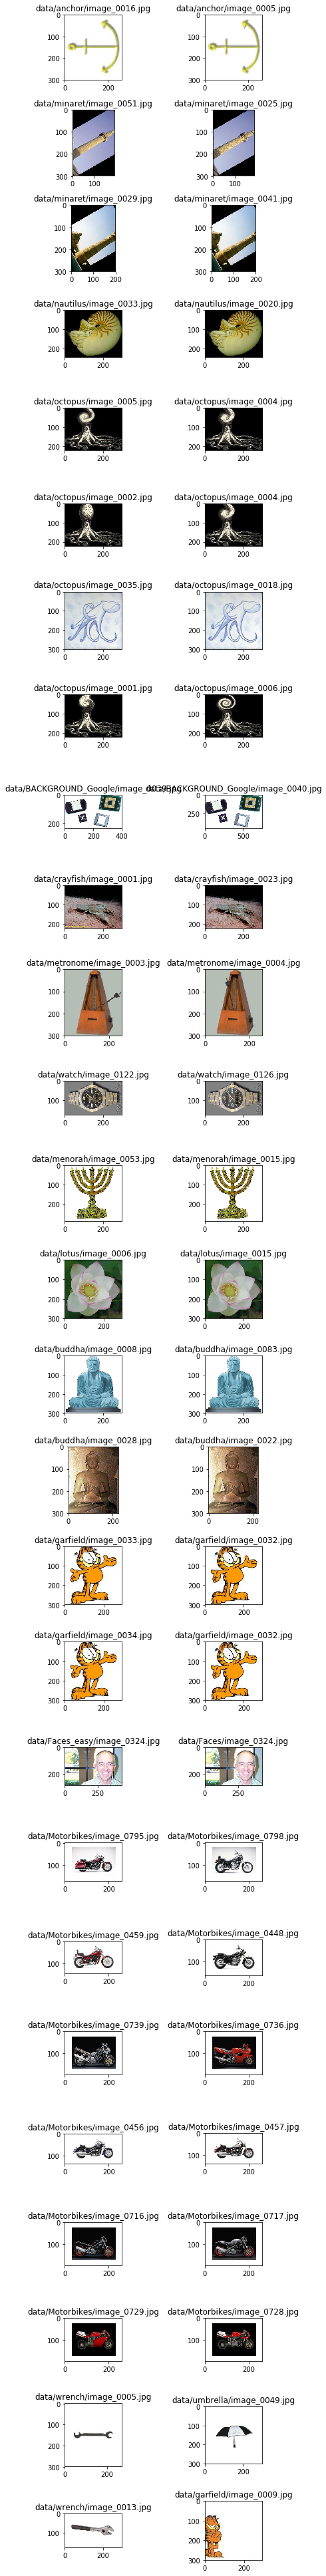

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

num = len(sims)

fig, axes = plt.subplots(nrows=num, ncols=2, figsize = (6, 2*num))

for i in range(num):
    for j in range(2):
        img = Image.open(sims[i][j])
        axes[i, j].set_title(sims[i][j])
        axes[i, j].imshow(img)

plt.tight_layout()
plt.savefig('docs/similarity.png')

## 分析

空间复杂度: 只需要4倍原始空间.

时间复杂度: 假设数据是均匀分布.

每个块的空间为 2^16 个
平均每个空间分布的数为 2^34/2^16 = 2^18 个
四个块返回的总结果数为 2^18*4 = 2^20 个

即最多需要比较 2^20 ≈ 100万次 hamming 距离.

## 未来
使用 key-value 数据库存储......